<h1> This notebook is used to test functionality of the code.
<h3> It contains an optimization loop with plotted objective function value over iterations and reconstruction of hyperspectral image.

In [1]:
import lmfit
from lmfit import Parameters,Minimizer
import random
import torch
from datetime import datetime
import os
from tqdm import tqdm
from utils_optimization.Set_up_dispersion_and_materials import set_up_dispersion_and_materials
from utils_optimization.functions_to_construct_objective_function import *
from utils_optimization.results_handling import save_results
import matplotlib.pyplot as plt

<h1> One run of optimization with lmfit

In [2]:
dtype=torch.float64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Initialization of initial conditions
n=10 # Number of slots for filters in each of the wheel
# Range of wavelengths points
wavelengths=torch.linspace(8000,14000,n**2-1,requires_grad=True)*1e-9 # Expressed in [m] as tmm_torch library requires
# Angles of incidence
angles = torch.linspace(0, 89, 90)

In [4]:
# Setting up material and dispersion models for simulation
Ti_mat,Au_mat,aSi_mat,env,subs=set_up_dispersion_and_materials(dtype,device)

In [5]:
def Objective_wrapper(params):
    """
    Lmfit wrapper of torch objective function.

     Args:
         params (lmfit.Parameters): parameters of thickness in lmfit compatible format

     Returns:
         residual_value (float): value obtained from torch defined objective function which was detached and projected to numpy format

     """
    # Converting lmfit.Parameters to torch.nn.Parameter
    param_tensor = lmfit_to_torch_values(params,dtype,device)

    # Global variables used for capturing value of objective function with each iteration
    global  Residuals_over#,Jacobian, Hessian

    # Jacobian and Hessian calculations
    #Jacobian=torch.autograd.functional.jacobian(Objective_expanded,param_tensor).detach().numpy()
    #Hessian=torch.autograd.functional.hessian(Objective_expanded,param_tensor).detach().numpy()

    # Residual from true objective function
    residual_value=objective(param_tensor,wavelengths,n,Au_mat,Ti_mat,aSi_mat,env,subs,angles,dtype,device,3.4)

    # Detaching residual from computational graph and appending it to history of residuals
    residual_value = residual_value.detach().numpy()
    Residuals_over.append(residual_value)

    return residual_value

In [6]:
# Defining parameters for the lmfit optimizer
params = Parameters()
# Thickness of the Ti
for i in range((n - 1) * 2):
    params.add(f'Ti_filter_{i + 1}', value=6e-9, min=1e-9, max=10e-9)

# Thickness of the Au
for i in range((n - 1) * 2):
    params.add(f'Au_filter_{i + 1}', value=6e-9, min=1e-9, max=10e-9)

# Thickness of the aSi
for i in range((n - 1) * 2):
    params.add(f'aSi_filter_{i + 1}', value=random.uniform(1000e-9, 10000e-9), min=1000e-9, max=10000e-9)


In [40]:
# This list stores objective value over iterations
Residuals_over = []

In [41]:
# Configuration of the optimizer
minimizer = Minimizer(Objective_wrapper, params)
result = minimizer.minimize(method='least_squares')

<h1> Results of optimization

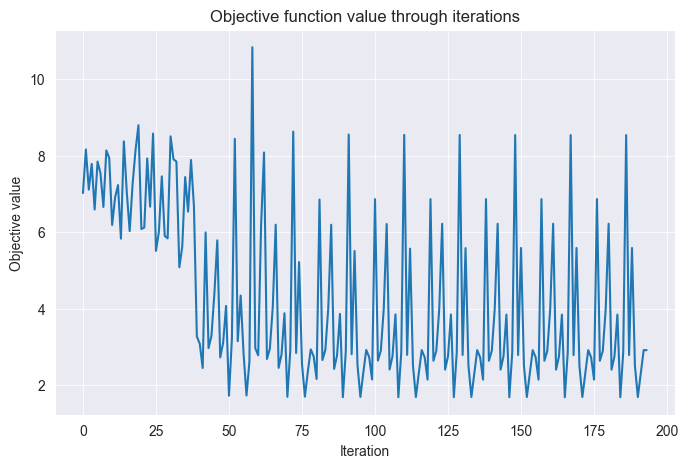

In [42]:
plt.figure(figsize=(8,5))
plt.plot(Residuals_over)
plt.grid(alpha=0.3)
plt.xlabel('Iteration')
plt.title('Objective function value through iterations')
plt.ylabel('Objective value')
plt.grid(alpha=0.8)

<h1> Comparing reconstruction of continuous function basis

In [11]:
# Basis of continues functions
Lorentzian=lorentzian(wavelengths,3.4,dtype,device)

In [12]:
# Obtained optimal parameters from optimization
opt_params=lmfit_to_torch_values(params,dtype,device)

In [13]:
# Matrix Psi containing products of encoder spectra built from optimal parameters
Psi_opt=filter_wheel(opt_params,n,Au_mat,Ti_mat,aSi_mat,env,subs,wavelengths,angles,dtype,device)

In [14]:
# Coefficient matrix constructed Psi_opt and using our target basis
C=Psi_opt@Lorentzian

In [15]:
# Lorentzian approximation using our optimal parameters
Lorentzian_app=torch.linalg.lstsq(Psi_opt,C,driver='gelsd')
Lorentzian_app=Lorentzian_app[0]
Lorentzian_app[Lorentzian_app<0]=0

Text(0, 0.5, 'Transmission [%]')

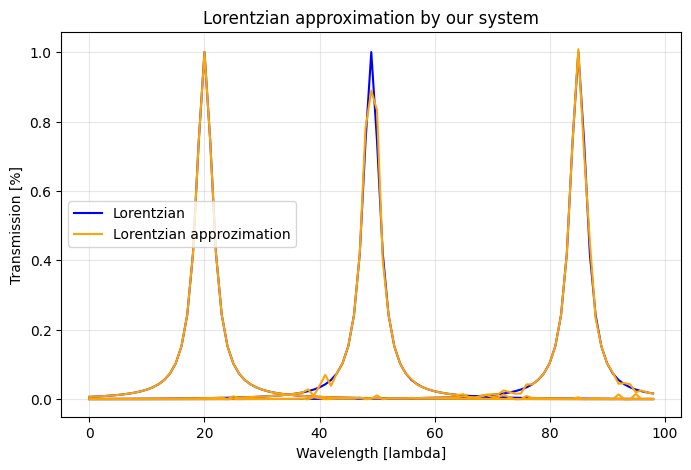

In [16]:
plt.figure(figsize=(8,5))
plt.title('Lorentzian approximation by our system')
plt.plot(Lorentzian[:,20].detach().numpy(),label='Lorentzian',color='blue')
plt.plot(Lorentzian[:,49].detach().numpy(),label='_nolegend_',color='blue')
plt.plot(Lorentzian[:,85].detach().numpy(),label='_nolegend_',color='blue')
plt.plot(Lorentzian_app[:,20].detach().numpy(),label='Lorentzian approzimation',color='orange')
plt.plot(Lorentzian_app[:,49].detach().numpy(),label='_nolegend_',color='orange')
plt.plot(Lorentzian_app[:,85].detach().numpy(),label='_nolegend_',color='orange')
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel('Wavelength [lambda]')
plt.ylabel('Transmission [%]')

<h1>Optimization but with sweep FWHM parameter

In [5]:
# Defining parameters for the lmfit optimizer
params = Parameters()
# Thickness of the Ti
for i in range((n - 1) * 2):
    params.add(f'Ti_filter_{i + 1}', value=6e-9, min=1e-9, max=10e-9)

# Thickness of the Au
for i in range((n - 1) * 2):
    params.add(f'Au_filter_{i + 1}', value=6e-9, min=1e-9, max=10e-9)

# Thickness of the aSi
for i in range((n - 1) * 2):
    params.add(f'aSi_filter_{i + 1}', value=random.uniform(1000e-9, 10000e-9), min=1000e-9, max=10000e-9)

params.add(f'Sweep_parameter',value=random.uniform(1,10),min=1,max=10)

In [6]:
torch_params=lmfit_to_torch_values(params,dtype,device)

In [12]:
loss=objective_bandwidth_sweep(torch_params,wavelengths,n,Au_mat,Ti_mat,aSi_mat,env,subs,angles,dtype,device,torch_params[-1])
# Loss=lorentzian_sweep(wavelengths,torch_params[-1],n,dtype,device)

/Users/jaworskj/DataspellProjects/General_purpose_hyperspectral_thermal_camera/torch_tmm/model.py:168: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:308.)
  n = layer.material.refractive_index(wavelengths).to(self.dtype).to(self.device)
